In [ ]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"✓ File '{filename}' uploaded successfully!\n")

Saving fraud_oracle.csv to fraud_oracle (1).csv
✓ File 'fraud_oracle (1).csv' uploaded successfully!



✓ Loaded 15420 rows and 33 columns
✓ Target column detected: FraudFound_P
✓ Features after encoding: 124

Training Random Forest model...
✓ Model trained successfully
✓ fraud_predictions.csv saved (Power BI ready)

Model Performance
Accuracy: 0.940
ROC-AUC: 0.858

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       1.00      0.01      0.01       185

    accuracy                           0.94      3084
   macro avg       0.97      0.50      0.49      3084
weighted avg       0.94      0.94      0.91      3084



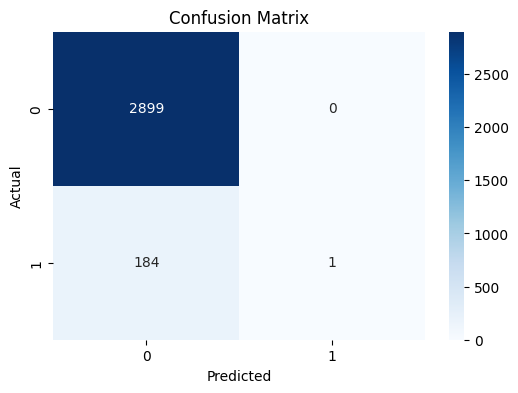

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# 1. LOAD DATA
# ==============================
filename = "fraud_oracle (1).csv"
df = pd.read_csv(filename, na_values=['?', 'UNKNOWN', 'nan'])
print(f"✓ Loaded {len(df)} rows and {len(df.columns)} columns")

# ==============================
# 2. DETECT TARGET COLUMN
# ==============================
target_options = [col for col in df.columns if 'fraud' in col.lower()]
if not target_options:
    raise ValueError("No fraud column found in the dataset!")
target = target_options[0]
print(f"✓ Target column detected: {target}")

# ==============================
# 3. DATA CLEANING
# ==============================
# Fill numeric missing values with median
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill categorical missing values with mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# ==============================
# 4. SEPARATE TARGET BEFORE ENCODING (CRITICAL)
# ==============================
y = df[target].apply(lambda x: 1 if str(x).lower() in ['y', 'yes', '1'] else 0)

# Drop target from features
X_raw = df.drop(columns=[target])

# ==============================
# 5. ENCODE CATEGORICAL FEATURES
# ==============================
cat_cols = X_raw.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

print(f"✓ Features after encoding: {X_encoded.shape[1]}")

# ==============================
# 6. TRAIN / TEST SPLIT
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 7. TRAIN RANDOM FOREST MODEL
# ==============================
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest model...")
model.fit(X_train, y_train)
print("✓ Model trained successfully")

# ==============================
# 8. PREDICTIONS
# ==============================
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# ==============================
# 9. SAVE PREDICTIONS FOR POWER BI (MOST IMPORTANT)
# ==============================
pred_df = X_test.copy()
pred_df['Actual'] = y_test.values
pred_df['Predicted'] = y_pred
pred_df['Fraud_Prob'] = y_prob

pred_df.to_csv('fraud_predictions.csv', index=False)
print("✓ fraud_predictions.csv saved (Power BI ready)")

# ==============================
# 10. MODEL EVALUATION
# ==============================
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance")
print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC: {auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cleaned_df = X_encoded.copy()
cleaned_df[target] = y.values
cleaned_df.to_csv('fraud_data_cleaned.csv', index=False)
files.download('fraud_predictions.csv')
